<h1><center>Transfer Learning with data augmentation</center></h1>

### Autor
- Nombre: Edwin Jahir Rueda Rojas
- email: ejrueda95g@gmail.com

- La finalidad de este notebook es aumentar un conjunto de imagenes por medio de rotaciones y aplicando zoom, para después entrenar la red neuronal convolucional propuesta en el taller 0 (<b>T0 - transfer learning with image generator.ipynb</b>)-
- Aplicar esta técnica de aumento de imágenes permite que el modelo que se construye sea mas generalizado, haciendo que su accuracy aumente en los datos de validación.

In [157]:
from PIL import Image
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from time import time
%matplotlib inline

#### Cargar los datos
- Note que los datos se cargan con un generador de tensorflow, esto en realidad no carga el dataset a la memoria RAM, simplemente crea <b>batches</b> los cuales en el momento de entrenar se cargan uno a uno, permitiendo consumir muy poca RAM.

In [4]:
batch_size = 64
img_height = 100
img_width = 100
data_root='../data/archive/raw-img/'
print("datos de entrenamiento")
data_train = tf.keras.preprocessing.image_dataset_from_directory(str(data_root),
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size,
                                                               label_mode='categorical')

print("datos de validación")
data_test = tf.keras.preprocessing.image_dataset_from_directory(str(data_root),
                                                               validation_split=0.2,
                                                               subset="validation",
                                                               seed=123,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size,
                                                               label_mode='categorical')

datos de entrenamiento
Found 26179 files belonging to 10 classes.
Using 2618 files for training.
datos de validación
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.


In [5]:
class_names = np.array(data_train.class_names)
print("categorias:", class_names)

categorias: ['cane' 'cavallo' 'elefante' 'farfalla' 'gallina' 'gatto' 'mucca' 'pecora'
 'ragno' 'scoiattolo']


In [6]:
for image_batch, labels_batch in data_train:
    print("Tamaño del batch de entrenamiento:", image_batch.shape)
    print("Tamaño del label para el batch:", labels_batch.shape)
    break

Tamaño del batch de entrenamiento: (64, 100, 100, 3)
Tamaño del label para el batch: (64, 10)


- Se carga la CNN pre-entrenada de imagenet y se ajusta su dimensión de entrada.

In [8]:
tl_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                       input_shape=(img_height,img_width,3))

### Aumento de los datos
- Para aumentar el conjunto de datos utilizamos tres capas principales:
    - <b> RandomFlip:</b> Para rotar la imagen sobre el eje horizontal
    - <b> RandomRotation:</b> Para rotar la imagen por grados en sentido horario.
    - <b> RandomZoom: </b> Para hacerle un zoom aleatorio a la imágen

In [160]:
model_augmentation = tf.keras.Sequential(name="augmentation_model")
model_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
model_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(.2, fill_mode="constant"))
model_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomZoom(.3, fill_mode="constant"))

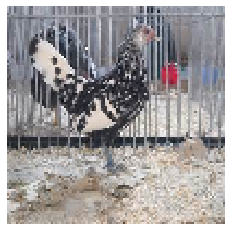

In [162]:
#img = Image.open("../data/archive/raw-img/gatto/465.jpeg").resize((100,100))
c = np.random.choice(os.listdir(data_root))
ruta_imagen = data_root + c + "/" + np.random.choice(os.listdir(data_root + c))
img = np.array(Image.open(ruta_imagen).resize((100,100)))
plt.imshow(img)
plt.axis("off");

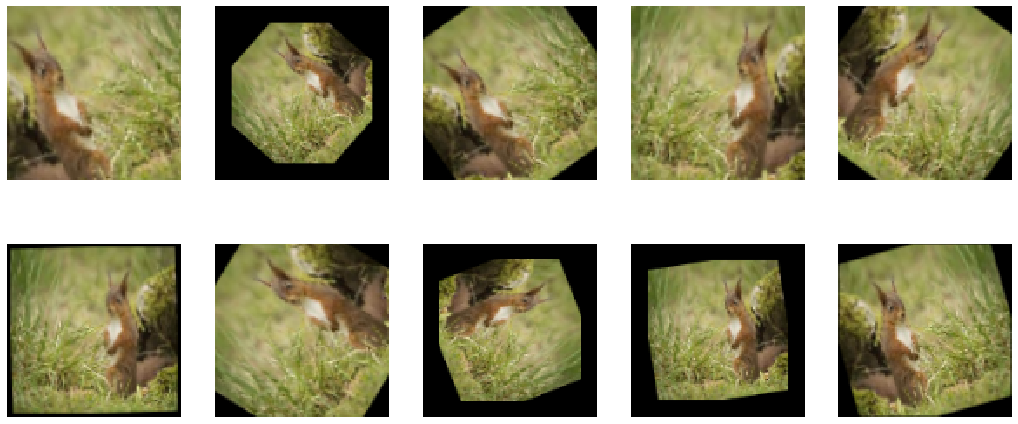

In [155]:
plt.figure(figsize=(18,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    img_pro = model_augmentation(np.array(img).reshape(1,100,100,3))
    plt.imshow(img_pro.numpy()[0])
    plt.axis("off")

- Añadimos el modelo <b>model_augmentation</b> a la CNN que teníamos.

In [104]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(model_augmentation)
model.add(tl_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dropout(.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics = ['accuracy'])

In [105]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
augmentation_model (Sequenti (None, 100, 100, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [106]:
hist = model.fit(data_train, epochs=3, validation_data=data_test)

Epoch 1/3
41/41 [==============================] - 609s 15s/step - loss: 1.6666 - accuracy: 0.4347 - val_loss: 1.6955 - val_accuracy: 0.4272
Epoch 2/3
41/41 [==============================] - 613s 15s/step - loss: 1.3940 - accuracy: 0.5057 - val_loss: 1.1502 - val_accuracy: 0.6148
Epoch 3/3
41/41 [==============================] - 622s 15s/step - loss: 1.1539 - accuracy: 0.5936 - val_loss: 1.1036 - val_accuracy: 0.6045


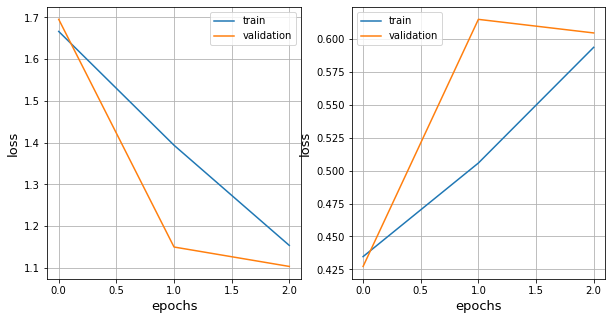

In [107]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("epochs", fontsize=13)
plt.ylabel("loss", fontsize=13)
plt.grid();

plt.subplot(1,2,2)
plt.plot(hist.history["accuracy"], label="train")
plt.plot(hist.history["val_accuracy"], label="validation")
plt.legend()
plt.xlabel("epochs", fontsize=13)
plt.ylabel("loss", fontsize=13)
plt.grid();

- guardamos los datos importantes

In [108]:
model.save("../models_aug/")

INFO:tensorflow:Assets written to: ../models_aug/assets


- ejecutamos el archivo <b>prediction.py</b> el cual nos sirve para predecir en base a un modelo

In [110]:
%run prediction.py

In [111]:
cnn = cnn_images_10(ruta_modelo="../models_aug/", ruta_translate="../translate.pk",
                   ruta_class="../class_name.pk")

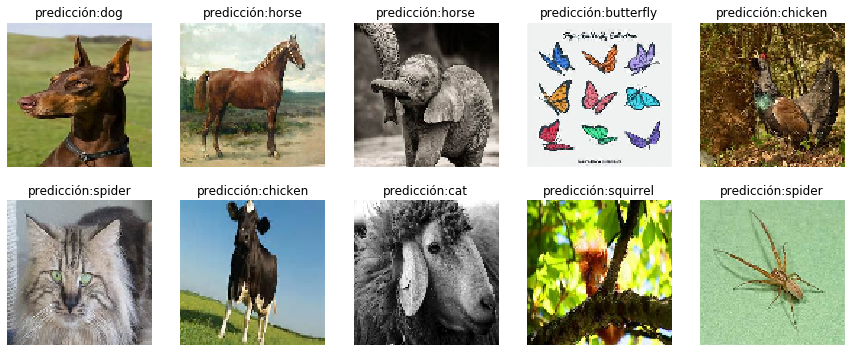

In [156]:
root='../data/archive/raw-img/'
plt.figure(figsize=(15,6))
count = 1
for c in cnn.translate.keys():
    #selecciono una ruta de imagen aleatoria
    ruta_imagen = np.random.choice(os.listdir("../data/archive/raw-img/" + c))
    plt.subplot(2,5,count)
    #print(root + ruta_imagen)
    ruta_completa = root + c + "/" + ruta_imagen
    plt.imshow(np.asarray(Image.open(ruta_completa).resize((100,100))))
    plt.axis("off")
    prediction = cnn.predict(ruta_completa)
    plt.title("predicción:"+prediction)
    count += 1